# What placements are best in 1v1 catan?
1. Cluster placement based on starting production summed
2. Find winrate by cluster

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.container import BarContainer
from typing import Optional, Any
from sklearn.cluster import KMeans

plt.style.use('ggplot')

In [2]:
# Prep dataframes: per player, and combined per game
path = "./games.csv"
games = pd.read_csv(path)

In [27]:
# Use per player production data
productionData = pd.DataFrame()

resources = ['Wood', 'Brick', 'Sheep', 'Wheat', 'Ore']
prefixes = ['FirstPlacementProd_', 'SecondPlacementProd_']
boardPrefix = "BoardProduction_"

for r in resources:
    # production summed (pips)
    # productionData[r] = games[prefixes[0] + r] + games[prefixes[1] + r]

    # log base 1.1 (1 + pips): distinguishes 0 and low production more
    productionData[r] = np.log(1 + games[prefixes[0] + r] + games[prefixes[1] + r]) / np.log(1.1)

    # ratio to the board
    # productionData[r] = (games[prefixes[0] + r] + games[prefixes[1] + r]) / games[boardPrefix + r]

    # log of ratio to the board
    # p = (games[prefixes[0] + r] + games[prefixes[1] + r]) / games[boardPrefix + r]
    # productionData[r] = np.log(0.1+p)/np.log(0.1)

productionData.head()

,Wood,Brick,Sheep,Wheat,Ore
0,14.545082,24.158858,16.886317,18.799246,16.886317
1,14.545082,14.545082,11.526705,23.053409,16.886317
2,14.545082,16.886317,18.799246,24.158858,16.886317
3,18.799246,21.817623,0.000000,11.526705,23.053409
4,18.799246,14.545082,11.526705,16.886317,21.817623


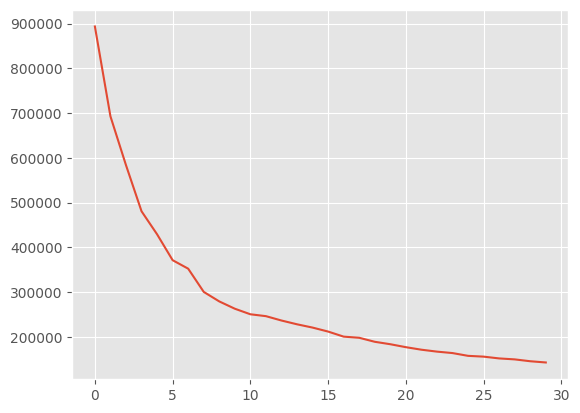

In [28]:
# Finding k for k-means
variations = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i, random_state=7)
    kmeans.fit(productionData)
    variations.append(kmeans.inertia_)

plt.plot(variations)

In [29]:
# Finding winrate of each cluster
kmeans = KMeans(n_clusters=7, random_state=7)
kmeans.fit(productionData)

clusters = pd.DataFrame(kmeans.cluster_centers_).round(1)
clusters.columns=resources
display(clusters)

# for clusters=8, random state=7
# clusterNames = ['Brick Balanced', 'Low Sheep', 'Road Builder', 'Ore Balanced', 'Balanced', 'Wood Balanced', 'Wheat Balanced', 'Sheep Balanced']
# predictions = [49, 45, 58, 58, 52, 49, 48, 51, 44] # Predictoins for winrates
games['Cluster'] = kmeans.labels_
# games['Cluster'] = games['Cluster'].apply(lambda x: clusterNames[x])

# games[['Cluster', 'Winner', 'GameId']]

,Wood,Brick,Sheep,Wheat,Ore
0,7.0,17.5,17.1,19.2,18.6
1,18.2,1.4,17.9,19.2,19.2
2,18.9,17.9,18.3,19.0,0.5
3,15.8,14.6,14.1,0.8,14.1
4,17.8,16.5,16.7,17.0,16.7
5,18.9,17.5,0.9,19.6,16.6
6,0.3,2.5,20.3,21.6,20.8


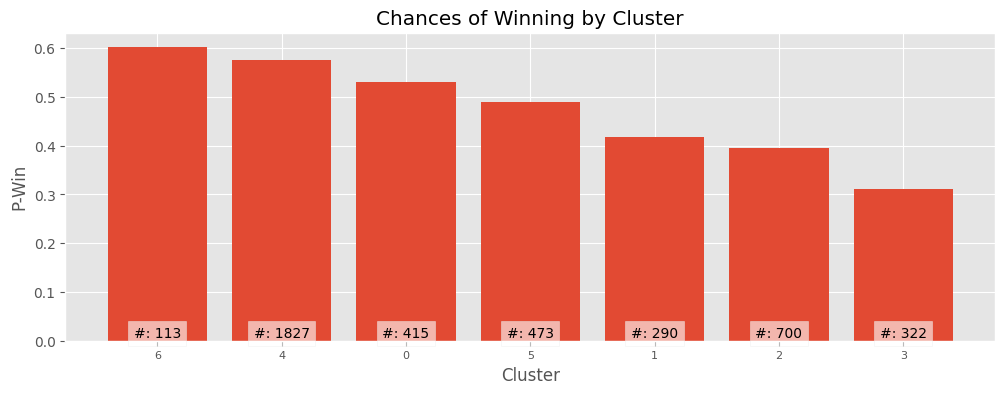

In [30]:
def plotWinPercentageBar(df: pd.DataFrame):
    if len(df.columns) != 2: raise ValueError("Df must have 2 cols: Winner and Data")
    if 'Winner' not in df.columns: raise ValueError("Df must have Winner column")

    dataCol = df.columns[0] if df.columns[1] == 'Winner' else df.columns[1]

    grouped = df.groupby(dataCol).agg(['mean', 'count'])
    grouped = grouped.sort_values(by=('Winner', 'mean'), ascending=False)
    grouped.index = grouped.index.astype(str)

    fig, ax = plt.subplots(figsize=(12, 4))
    bars = ax.bar(grouped.index, grouped['Winner']['mean'])
    ax.set_xlabel(dataCol)
    ax.set_ylabel('P-Win')
    ax.set_title(f'Chances of Winning by {dataCol}')
    ax.tick_params(axis='x', labelsize=8)

    for i, bar in enumerate(bars):
        count = int(grouped.iloc[i, :]['Winner']['count'])
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_y(), f'#: {count}',
                ha='center', va='bottom',
                bbox=dict(facecolor='white', alpha=0.6))

plotWinPercentageBar(games[['Winner', 'Cluster']])

In [8]:
# Look at games from a certain cluster
games[games['Cluster']==3]['GameId']

31      -NyDVdp4Hrx1sZmxkWKS
40      -NyDNLol8R2JK7u9Ad2O
64      -NyGlxxfvmYoS5qx6wEO
104     -O1AFMCpdcDeFqPDRYWC
108     -O1E48i5LPAePkEuTb0N
                ...         
4067    -O0txeWbDsQj2j6Ptlpj
4088    -O-O2BWkns_SoM3gAXi3
4113    -O-NPOWrgRikuPIGJY82
4124    -O-MM9XDgukHln_zE-OE
4137    -O5lfWLTpWWq1dZiUNfs
Name: GameId, Length: 285, dtype: object

Text(0.5, 1.02, 'Annotations are # samples')

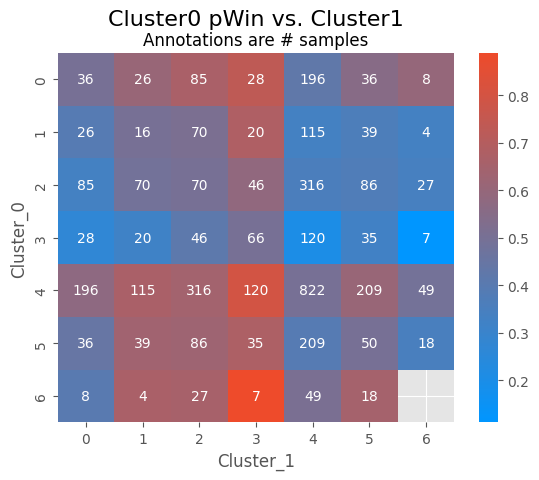

In [66]:
# Now, create the combined df to see how matchups are
combinedGames = games
combinedGames = combinedGames.pivot(index='GameId', columns='PlacementOrder')
combinedGames.columns = [f'{col[0]}_{col[1]}' for col in combinedGames.columns]

clusterPairs0 = combinedGames.groupby(by=['Cluster_0', 'Cluster_1'])
totalPairs0 = clusterPairs0.size().unstack()
clusterPairs0 = clusterPairs0['Winner_0'].sum().unstack()

clusterPairs1 = combinedGames.groupby(by=['Cluster_1', 'Cluster_0'])
totalPairs1 = clusterPairs1.size().unstack()
clusterPairs1 = clusterPairs1['Winner_1'].sum().unstack()

clusterCombined = clusterPairs0 + clusterPairs1
totalCombined = totalPairs0 + totalPairs1
modifiedPercentages = (clusterCombined+1) / (totalCombined+2)

color = sns.color_palette("blend:#0096FF,#EE4B2B", as_cmap=True)
sns.heatmap(modifiedPercentages, annot=totalCombined.fillna(0).astype(int), fmt='d', cmap=color)
plt.title('Cluster0 pWin vs. Cluster1', fontsize=16, pad=20)
plt.text(0.5, 1.02, "Annotations are # samples", fontsize=12, ha='center', transform=plt.gca().transAxes)